In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf
from scipy.signal import butter, filtfilt


In [2]:
# Set memory limit for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
            )
        print("Memory limit set to 4096 MB for each GPU.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")


Memory limit set to 4096 MB for each GPU.


In [3]:
# Parameters
target_sample_rate = 16000
n_fft = 2048
hop_length = 512
n_mels = 128
clip_duration = 5
clip_samples = int(clip_duration * target_sample_rate)
negative_dir = 'dataset/Negative'
weevil_dir = 'dataset/S_oryzae'
rd_dir = 'dataset/R_dominica'
tc_dir = 'dataset/T_castaneum'

In [4]:
low_cutoff = 93.75  # Low-pass cut-off frequency in Hz
high_cutoff = 2500  # High-pass cut-off frequency in Hz
filter_order = 4    # Order of the filter

# Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, sr, order=4):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Applying band-pass filter to an audio signal
def bandpass_filter(data, lowcut, highcut, sr, order=4):
    b, a = butter_bandpass(lowcut, highcut, sr, order=order)
    y = filtfilt(b, a, data)  # Apply the filter to the data
    return y

In [5]:
from sklearn.preprocessing import LabelEncoder

def preprocess_audio_rnn(file_path):
    """
    Preprocess an audio file for RNN input using Mel Spectrograms.
    Args:
        file_path (str): Path to the audio file.
    Returns:
        List of feature sequences for the RNN.
    """
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=target_sample_rate)

    # Apply bandpass filter
    audio = bandpass_filter(
        audio, lowcut=low_cutoff, highcut=high_cutoff,
        sr=target_sample_rate, order=filter_order
    )
    
    # Normalize audio
    audio = audio / np.max(np.abs(audio))
    
    # Split into fixed-duration clips
    segments = []
    for i in range(0, len(audio), clip_samples):
        clip = audio[i:i + clip_samples]
        
        # Pad if shorter than target duration
        if len(clip) < clip_samples:
            clip = np.pad(clip, (0, clip_samples - len(clip)), mode='constant')
        
        # Extract Mel Spectrogram features
        mel_spectrogram = librosa.feature.melspectrogram(y=clip, sr=target_sample_rate, 
                                                         n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Normalize Mel Spectrogram features
        epsilon = 1e-8  # Small value to avoid division by zero
        log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean(axis=0)) / (log_mel_spectrogram.std(axis=0) + epsilon)
        
        # Transpose to shape (timesteps, features)
        log_mel_spectrogram = log_mel_spectrogram.T
        
        segments.append(log_mel_spectrogram)
    
    return segments

def process_dataset_for_rnn(dataset_dir, class_labels):
    """
    Preprocess all audio files in the dataset for RNN input using Mel Spectrograms.
    Args:
        dataset_dir (str): Path to the dataset folder containing subfolders for each class.
        class_labels (list): List of class labels corresponding to subfolders.
    Returns:
        Tuple (X, y): Features and labels for RNN training.
    """
    X, y = [], []
    label_encoder = LabelEncoder()
    label_encoder.fit(class_labels)
    
    for label in class_labels:
        class_dir = os.path.join(dataset_dir, label)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                segments = preprocess_audio_rnn(file_path)
                
                # Append features and labels
                X.extend(segments)
                y.extend([label_encoder.transform([label])[0]] * len(segments))
    
    return np.array(X), np.array(y)

In [6]:
dataset_dir = "dataset"
class_labels = ["negative", "rice_weevil", "r_dominica", "t_castaneum"]
X, y = process_dataset_for_rnn(dataset_dir, class_labels)

print("Features shape:", X.shape)  # Should be (num_samples, timesteps, features)
print("Labels shape:", y.shape)    # Should be (num_samples,)

Features shape: (5000, 157, 128)
Labels shape: (5000,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
    )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
    )

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

# Define parameters
input_shape = (157, 128)
num_classes = 4

# Build the model
model = Sequential([
    # LSTM layer with dropout
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.5),

    # Additional LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    # Fully connected layer
    Dense(64, activation='relu'),
    BatchNormalization(),  # Batch normalization to improve stability
    Dropout(0.5),  # Additional Dropout for the dense layer

    # Output layer with softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 157, 128)          131584    
                                                                 
 dropout_17 (Dropout)        (None, 157, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=25,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True
                               )

checkpoint = ModelCheckpoint('rnn_weevil.h5',
                             save_best_only=True
                             )

In [29]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/150
125/125 [==============================] - 8s 42ms/step - loss: 1.7912 - accuracy: 0.3735 - val_loss: 1.0938 - val_accuracy: 0.5220
Epoch 2/150
125/125 [==============================] - 4s 34ms/step - loss: 1.3650 - accuracy: 0.5025 - val_loss: 0.7777 - val_accuracy: 0.6840
Epoch 3/150
125/125 [==============================] - 4s 34ms/step - loss: 1.0496 - accuracy: 0.5880 - val_loss: 0.5478 - val_accuracy: 0.7780
Epoch 4/150
125/125 [==============================] - 4s 34ms/step - loss: 0.9506 - accuracy: 0.6230 - val_loss: 0.4778 - val_accuracy: 0.8300
Epoch 5/150
125/125 [==============================] - 4s 33ms/step - loss: 0.8267 - accuracy: 0.6785 - val_loss: 0.5033 - val_accuracy: 0.7680
Epoch 6/150
125/125 [==============================] - 4s 34ms/step - loss: 0.6734 - accuracy: 0.7255 - val_loss: 0.2977 - val_accuracy: 0.8820
Epoch 7/150
125/125 [==============================] - 4s 34ms/step - loss: 0.6143 - accuracy: 0.7615 - val_loss: 0.2688 - val_accuracy:

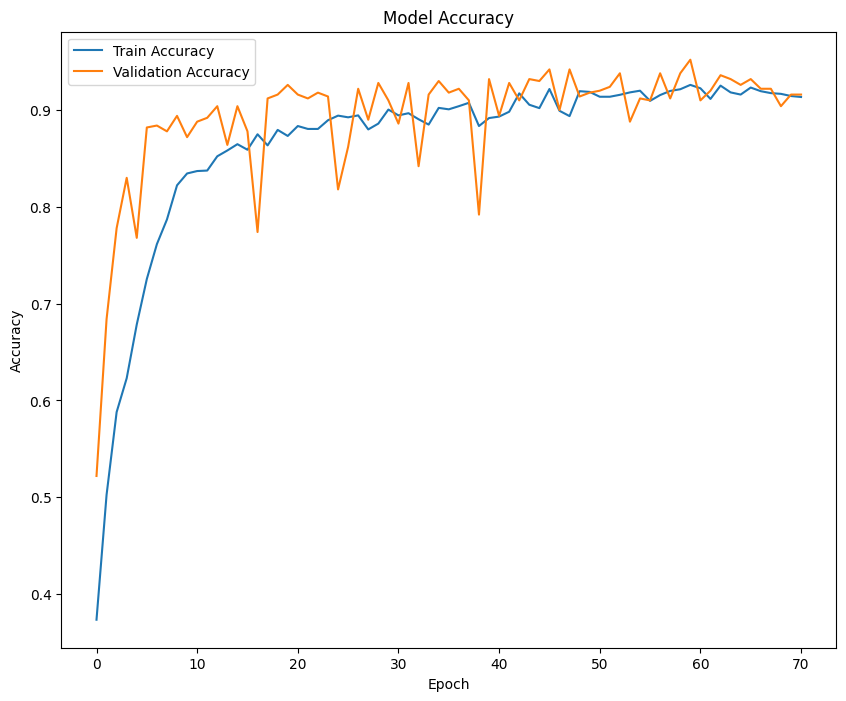

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

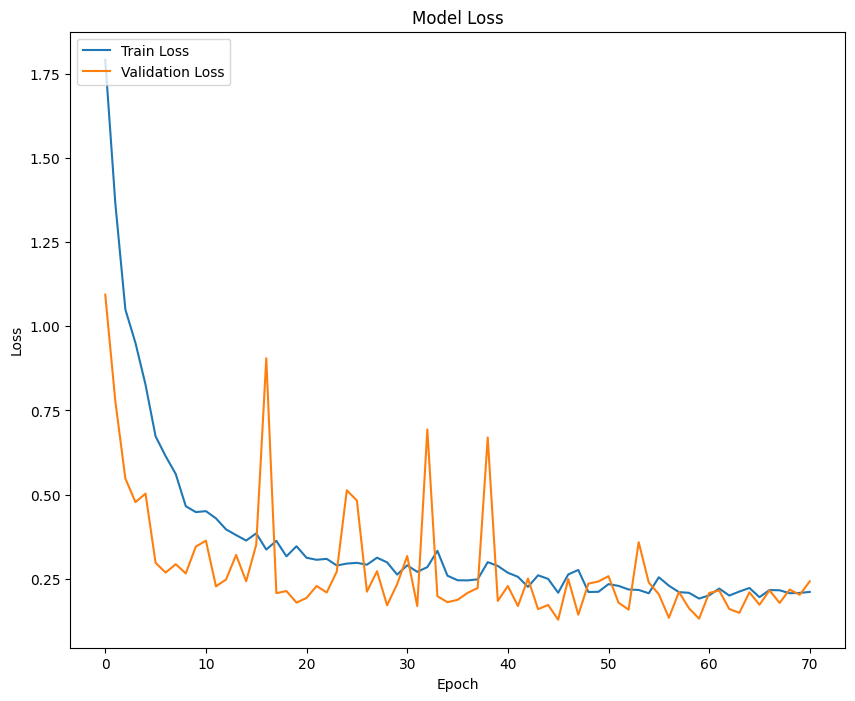

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

16/16 [==============================] - 0s 22ms/step - loss: 0.1518 - accuracy: 0.9440
Test accuracy: 0.9440
Test loss: 0.1518


In [33]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

16/16 [==============================] - 1s 15ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, predicted_labels, target_names=['rice_weevil', 'negative', 'r_dominica', 't_castaneum']))

Classification Report:
              precision    recall  f1-score   support

 rice_weevil       1.00      1.00      1.00       202
    negative       0.92      0.86      0.89       107
  r_dominica       0.83      0.90      0.86        96
 t_castaneum       0.97      0.98      0.97        95

    accuracy                           0.94       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.95      0.94      0.94       500



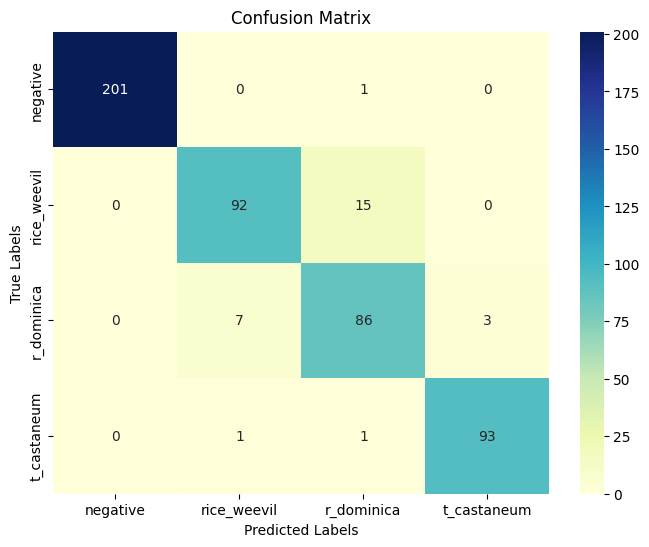

In [36]:
import seaborn as sns

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["negative", "rice_weevil", "r_dominica", "t_castaneum"], yticklabels=["negative", "rice_weevil", "r_dominica", "t_castaneum"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
